In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
#export
from exp.nb_05b import *
torch.set_num_threads(2)

## ConvNet

In [3]:
x_train, y_train, x_valid, y_valid = get_mnist_data()

Helper function to quickly normalize with the mean and standard deviation from our training set

In [4]:
#export
def normalize_to(train, valid):
  m = train.mean()
  s = train.std()
  return normalize(train, m, s), normalize(valid, m, s)

In [5]:
x_train, x_valid = normalize_to(x_train, x_valid)
train_ds = Dataset(x_train, y_train)
valid_ds = Dataset(x_valid, y_valid)

Let's check it behaved properly

In [6]:
x_train.mean(), x_train.std()

(tensor(3.0614e-05), tensor(1.))

In [7]:
nh, bs = 50, 512
c = y_train.max().item() + 1
loss_func = F.cross_entropy

data = DataBunch(*get_dls(train_ds, valid_ds, bs), c)

In [8]:
train_dl, valid_dl = get_dls(train_ds, valid_ds, bs)

In [9]:
len(valid_dl)

10

To refactor layers, it's useful to have a `Lambda` layer that can take a basic function and convert it to a layer you can put in `nn.Sequential`.

NB: if you use a Lambda layer with a lambda function, your model won't pickle so you won't be able to save it with Pytorch. So it's best to give a name to the function you're using inside your Lambda (like flatten below).

In [10]:
#export
class Lambda(nn.Module):
  def __init__(self, func):
    super(Lambda, self).__init__()
    self.func = func
    
  def forward(self, x):
    return self.func(x)
  
def flatten(x):
  return x.view(x.shape[0], -1)

This one takes the flat vector of size `bs x 784` and puts it back as a batch of images of 28 by 28 pixels

In [11]:
def mnist_resize(x):
  return x.view(-1, 1, 28, 28)

We can now define a simple CNN.

In [12]:
def get_cnn_model(data):
  return nn.Sequential(
    Lambda(mnist_resize),
    nn.Conv2d(1, 8, 5, padding=2, stride=2), #14
    nn.ReLU(),
    nn.Conv2d(8, 16, 3, padding=1, stride=2), #7
    nn.ReLU(),
    nn.Conv2d(16, 32, 3, padding=1, stride=2), #4
    nn.ReLU(),
    nn.Conv2d(32, 32, 3, padding=1, stride=2), #2
    nn.ReLU(),
    nn.AdaptiveAvgPool2d(1),
    Lambda(flatten),
    nn.Linear(32, data.c)
  )

In [13]:
model = get_cnn_model(data)

Basic callbacks from the previous notebook:

In [14]:
cbfs = [Recorder, partial(AvgStatsCallback, accuracy)]

In [15]:
opt = optim.SGD(model.parameters(), lr=0.4)
learn = Learner(model, opt, loss_func, data)
run = Runner(cb_funcs=cbfs)

In [16]:
%time run.fit(1, learn)

train: [2.17490359375, tensor(0.2066)]
valid: [1.260168359375, tensor(0.5794)]
CPU times: user 3.88 s, sys: 7.48 ms, total: 3.89 s
Wall time: 1.96 s


## CUDA

This took a long time to run, so it's time to use a GPU. A simple Callback can make sure the model, inputs and targets are all on the same device.

In [17]:
device = torch.device('cuda', 0)

In [18]:
# Somewhat less flexible, but quite convenient
# torch.cuda.set_device(device)

In [19]:
class CudaCallback(Callback):
  def begin_fit(self):
    self.model.cuda()
    
  def begin_batch(self):
    self.run.xb = self.run.xb.cuda()
    self.run.yb = self.run.yb.cuda()

In [20]:
#export
class CudaCallback(Callback):
  def __init__(self, device):
    self.device = device
    
  def begin_fit(self):
    self.model.to(self.device)
    
  def begin_batch(self):
    self.run.xb = self.run.xb.to(self.device)
    self.run.yb = self.run.yb.to(self.device)

In [21]:
cbfs.append(partial(CudaCallback, device))

In [22]:
model = get_cnn_model(data)

In [23]:
opt = optim.SGD(model.parameters(), lr=0.4)
learn = Learner(model, opt, loss_func, data)
run = Runner(cb_funcs=cbfs)

In [24]:
%time run.fit(3, learn)

train: [2.08998625, tensor(0.2519, device='cuda:0')]
valid: [0.91538544921875, tensor(0.7080, device='cuda:0')]
train: [0.47924125, tensor(0.8486, device='cuda:0')]
valid: [0.2581905029296875, tensor(0.9241, device='cuda:0')]
train: [0.22327107421875, tensor(0.9314, device='cuda:0')]
valid: [0.16685067138671875, tensor(0.9497, device='cuda:0')]
CPU times: user 4.19 s, sys: 385 ms, total: 4.58 s
Wall time: 4.54 s


Now, that's definitely faster.

## Refactor model

First we can regroup all the conv/relu in a single function

In [25]:
def conv2d(ni, nf, ks=3, stride=2):
  return nn.Sequential(nn.Conv2d(ni, nf, ks, padding=ks//2, stride=stride),
                       nn.ReLU())

Another thing is that we can do the mnist resize in a batch transform, that we can do with a Callback.

In [26]:
#export
class BatchTransformXCallback(Callback):
  _order=2
  def __init__(self, tfm):
    self.tfm = tfm
    
  def begin_batch(self):
    self.run.xb = self.tfm(self.run.xb)
    
def view_tfm(*size):
  def _inner(x):
    return x.view(*((-1,) + size))
  return _inner

In [27]:
mnist_resize = view_tfm(1, 28, 28)
cbfs.append(partial(BatchTransformXCallback, mnist_resize))

With the `AdaptiveAvgPool`, this model can now work on any size input

In [28]:
nfs = [8, 16, 32, 32]

In [29]:
def get_cnn_layers(data, nfs):
  nfs = [1] + nfs
  return [conv2d(nfs[i], nfs[i + 1], ks=5 if i == 0 else 3, stride=2) for i in range(len(nfs) - 1)
         ] + [nn.AdaptiveAvgPool2d(1), Lambda(flatten), nn.Linear(nfs[-1], data.c)]

def get_cnn_model(data, nfs):
  return nn.Sequential(*get_cnn_layers(data, nfs))

And this helper function will quickly give us everything needed to run the training.

In [30]:
#export
def get_runner(model, data, lr=0.6, cbs=None, opt_func=None, loss_func=F.cross_entropy):
  if opt_func is None:
    opt_func = optim.SGD
  opt = opt_func(model.parameters(), lr=lr)
  learn = Learner(model, opt, loss_func, data)
  run = Runner(cb_funcs=listify(cbs))
  return learn, run

In [31]:
model = get_cnn_model(data, nfs)
learn, run = get_runner(model, data, lr=0.4, cbs=cbfs)

In [32]:
model

Sequential(
  (0): Sequential(
    (0): Conv2d(1, 8, kernel_size=(5, 5), stride=(2, 2), padding=(2, 2))
    (1): ReLU()
  )
  (1): Sequential(
    (0): Conv2d(8, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (1): ReLU()
  )
  (2): Sequential(
    (0): Conv2d(16, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (1): ReLU()
  )
  (3): Sequential(
    (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (1): ReLU()
  )
  (4): AdaptiveAvgPool2d(output_size=1)
  (5): Lambda()
  (6): Linear(in_features=32, out_features=10, bias=True)
)

In [33]:
run.fit(3, learn)

train: [1.9323646875, tensor(0.3174, device='cuda:0')]
valid: [0.7050099609375, tensor(0.7773, device='cuda:0')]
train: [0.42591171875, tensor(0.8654, device='cuda:0')]
valid: [0.19802462158203124, tensor(0.9432, device='cuda:0')]
train: [0.17991611328125, tensor(0.9460, device='cuda:0')]
valid: [0.1354489990234375, tensor(0.9617, device='cuda:0')]


## Hooks
### Manual insertion
Let's say we want to do some telemetry, and want the mean and standard deviation of each activations in the model. First we can do it manually like this:

In [34]:
class SequentialModel(nn.Module):
  def __init__(self, *layers):
    super(SequentialModel, self).__init__()
    self.layers = nn.ModuleList(layers)
    self.act_means = [[] for _ in layers]
    self.act_stds = [[] for _ in layers]
    
  def __call__(self, x):
    for i, l in enumerate(self.layers):
      x = l(x)
      self.act_means[i].append(x.data.mean())
      self.act_stds[i].append(x.data.std())
    return x
  
  def __iter__(self):
    return iter(self.layers)

In [35]:
model = SequentialModel(*get_cnn_layers(data, nfs))
learn, run = get_runner(model, data, lr=0.9, cbs=cbfs)

In [36]:
run.fit(2, learn)

train: [2.35321203125, tensor(0.1447, device='cuda:0')]
valid: [2.28476953125, tensor(0.1628, device='cuda:0')]
train: [1.4315296875, tensor(0.5024, device='cuda:0')]
valid: [0.68702685546875, tensor(0.7662, device='cuda:0')]


Now we can have a look at the means and stds of the activations at the beginning of training.

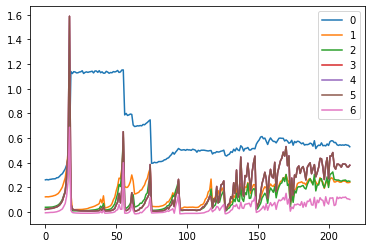

In [37]:
for i, l in enumerate(model.act_means):
  plt.plot(l, label=i)
plt.legend();

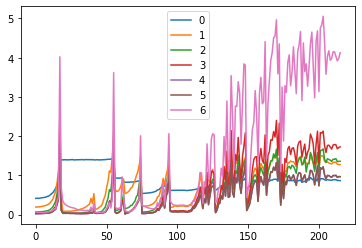

In [38]:
for i, l in enumerate(model.act_stds):
  plt.plot(l, label=i)
plt.legend();

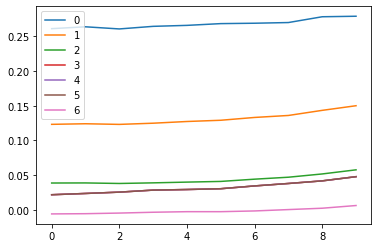

In [39]:
for i, l in enumerate(model.act_means):
  plt.plot(l[:10], label=i)
plt.legend();

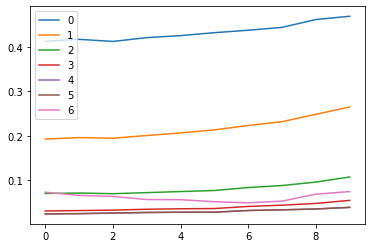

In [40]:
for i, l in enumerate(model.act_stds):
  plt.plot(l[:10], label=i)
plt.legend();

### Pytorch hooks
Hooks are PyTorch object you can add to any `nn.Module`. A hook will be called when a layer, it is registered to, is executed during the forward pass (forward hook) or the packward pass (backward hook).
Hooks don't require us to rewrite the model.

In [41]:
model = get_cnn_model(data, nfs)
learn, run = get_runner(model, data, lr=0.5, cbs=cbfs)

In [42]:
act_means = [[] for _ in model]
act_stds = [[] for _ in model]

A hook is attached to a layer, and needs to have a function that takes 3 argurments: module, input, output. Here we store the mean and std of the output in the correct position of our list.

In [43]:
def append_stats(i, mod, inp, outp):
  act_means[i].append(outp.data.mean())
  act_stds[i].append(outp.data.std())

In [44]:
for i, m in enumerate(model):
  m.register_forward_hook(partial(append_stats, i))

In [45]:
run.fit(1, learn)

train: [2.2472659375, tensor(0.1932, device='cuda:0')]
valid: [2.1315125, tensor(0.1615, device='cuda:0')]


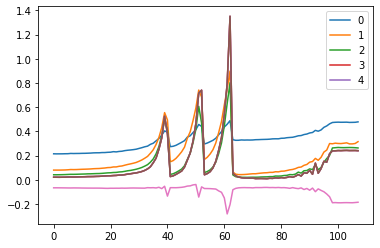

In [46]:
for o in act_means: plt.plot(o)
plt.legend(range(5));

### Hook class
We can refactor this in a Hook class. It's very important to remove the hooks when they are deleted, otherwise there will be references kept and the memory won't be properly released when your model is deleted.

In [47]:
#export
def children(m):
  return list(m.children())

class Hook():
  def __init__(self, m, f):
    self.hook = m.register_forward_hook(partial(f, self))
  
  def remove(self):
    self.hook.remove()
    
  def __del__(self):
    self.remove()
    
def append_stats(hook, mod, inp, outp):
  if not hasattr(hook, 'stats'):
    hook.stats = ([], [])
  means, stds = hook.stats
  means.append(outp.data.mean())
  stds.append(outp.data.std())

NB: In fastai they use a `bool` param to choose whether to make it forward or backward hook. In the above version, we're only supporting forward hooks.

In [48]:
model = get_cnn_model(data, nfs)
learn, run = get_runner(model, data, lr=0.5, cbs=cbfs)

In [49]:
hooks = [Hook(l, append_stats) for l in children(model[:4])]

In [50]:
run.fit(1, learn)

train: [2.02186328125, tensor(0.2854, device='cuda:0')]
valid: [1.56837509765625, tensor(0.4662, device='cuda:0')]


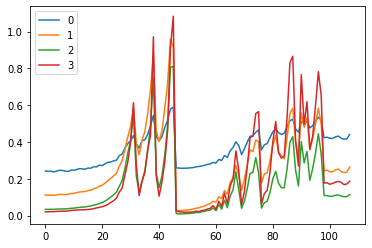

In [51]:
for h in hooks:
  plt.plot(h.stats[0])
  h.remove()
plt.legend(range(4));

### A Hooks class
Let's design our own class that can contain a list of objects. It will behave a bit like a numpy array in the sense that we can index into it via:
- a single index
- a slice (like 1:5)
- a list of indices
- a mask of indices([True, False, False, True, ...])

The `__iter__` method is there to be able to do things like `for x in ...`.

In [52]:
#export
class ListContainer():
  def __init__(self, items):
    self.items = listify(items)
    
  def __getitem__(self, idx):
    if isinstance(idx, (int, slice)):
      return self.items[idx]
    if isinstance(idx, torch.Tensor) and len(idx.size()) == 0: # Handle 0-dim tensor
      return self.items[idx.item()]
    if isinstance(idx[0], bool):
      assert len(idx) == len(self) # bool mask
      return [o for m, o in zip(idx, self.items) if m]
    return [self.items[i] for i in idx]
  
  def __len__(self):
    return len(self.items)
  
  def __iter__(self):
    return iter(self.items)
  
  def __setitem__(self, i, o):
    self.items[i] = o
    
  def __delitem__(self, i):
    del(self.items[i])
    
  def __repr__(self):
    res = f'{self.__class__.__name__} ({len(self)} items)\n{self.items[:10]}'
    if len(self) > 10:
      res = res[:-1] + '...]'
    return res

In [53]:
ListContainer(range(10))

ListContainer (10 items)
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9]

In [54]:
ListContainer(range(100))

ListContainer (100 items)
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9...]

In [55]:
t = ListContainer(range(10))
t[[1, 2]], t[[False] * 8 + [True, False]]

([1, 2], [8])

We can use it to write a `Hooks` class that contains several hooks. We will also use it in the next notebook as a container for our objects in the data block API.

In [56]:
#export
from torch.nn import init

class Hooks(ListContainer):
  def __init__(self, ms, f):
    super(Hooks, self).__init__([Hook(m, f) for m in ms])
    
  def __enter__(self, *args):
    return self
  
  def __exit__(self, *args):
    self.remove()
    
  def __del__(self):
    self.remove()
    
  def __delitem__(self, i):
    self[i].remove()
    super().__delitem__(i)
    
  def remove(self):
    for h in self:
      h.remove()

In [57]:
model = get_cnn_model(data, nfs).to(device)
learn, run = get_runner(model, data, lr=0.9, cbs=cbfs)

In [58]:
hooks = Hooks(model, append_stats)
hooks

Hooks (7 items)
[<__main__.Hook object at 0x7f6a4768aa90>, <__main__.Hook object at 0x7f6a47677550>, <__main__.Hook object at 0x7f6a476776a0>, <__main__.Hook object at 0x7f6a47677d30>, <__main__.Hook object at 0x7f6a497f1e10>, <__main__.Hook object at 0x7f6a497f14e0>, <__main__.Hook object at 0x7f6a497f1ef0>]

In [59]:
hooks.remove()

In [60]:
x, y = next(iter(data.train_dl))
x = mnist_resize(x).to(device)

In [61]:
x.mean(), x.std()

(tensor(-0.0013, device='cuda:0'), tensor(0.9988, device='cuda:0'))

In [62]:
p = model[0](x)
p.mean(), p.std()

(tensor(0.1942, device='cuda:0', grad_fn=<MeanBackward0>),
 tensor(0.3102, device='cuda:0', grad_fn=<StdBackward0>))

In [63]:
for l in model:
  if isinstance(l, nn.Sequential):
    init.kaiming_normal_(l[0].weight)
    l[0].bias.data.zero_()

In [64]:
p = model[0](x)
p.mean(), p.std()

(tensor(0.4958, device='cuda:0', grad_fn=<MeanBackward0>),
 tensor(0.8590, device='cuda:0', grad_fn=<StdBackward0>))

Having given an `__enter__` and `__exit__` method to our `Hooks` class, we can use it as a context manager. This makes sure that onces we are out of the `with` block, all the hooks have been removed and aren't there to pollute our memory.

train: [1.666608125, tensor(0.4521, device='cuda:0')]
valid: [0.64058291015625, tensor(0.7824, device='cuda:0')]
train: [0.31159462890625, tensor(0.9030, device='cuda:0')]
valid: [0.14409283447265625, tensor(0.9544, device='cuda:0')]


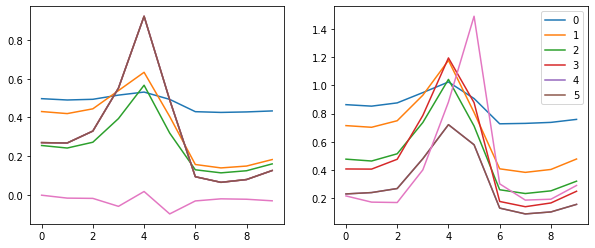

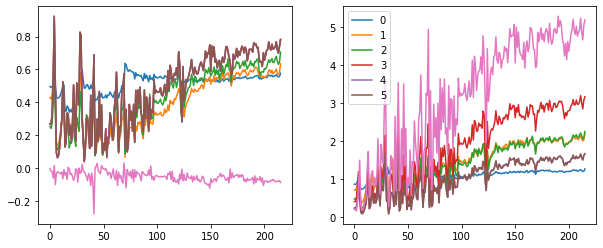

In [65]:
with Hooks(model, append_stats) as hooks:
  run.fit(2, learn)
  fig, (ax0, ax1) = plt.subplots(1, 2, figsize=(10, 4))
  for h in hooks:
    ms, ss = h.stats
    ax0.plot(ms[:10])
    ax1.plot(ss[:10])
  plt.legend(range(6));
  
  fig, (ax0, ax1) = plt.subplots(1, 2, figsize=(10, 4))
  for h in hooks:
    ms, ss = h.stats
    ax0.plot(ms)
    ax1.plot(ss)
  plt.legend(range(6));

### Other statistics
Let's store more than the means and stds and plot histograms fo our activations now.

In [66]:
def append_stats(hook, mod, inp, outp):
  if not hasattr(hook, 'stats'):
    hook.stats = ([], [], [])
  means, stds, hists = hook.stats
  means.append(outp.data.mean().cpu())
  stds.append(outp.data.std().cpu())
  hists.append(outp.data.cpu().histc(40, 0, 10)) # histc isn't implemented on the GPU

In [67]:
model = get_cnn_model(data, nfs).to(device)
learn, run = get_runner(model, data, lr=0.9, cbs=cbfs)

In [68]:
for l in model:
  if isinstance(l, nn.Sequential):
    init.kaiming_normal_(l[0].weight)
    l[0].bias.data.zero_()

In [69]:
with Hooks(model, append_stats) as hooks:
  run.fit(1, learn)

train: [2.35209328125, tensor(0.1685, device='cuda:0')]
valid: [1.9513275390625, tensor(0.2374, device='cuda:0')]


In [70]:
def get_hist(h):
  return torch.stack(h.stats[2]).t().float().log1p()

In [71]:
torch.stack(hooks[0].stats[2]).t().float().log1p()

tensor([[13.2134, 13.2242, 13.2774,  ..., 13.7929, 13.7963, 13.5410],
        [11.6502, 11.7046, 11.3693,  ..., 10.4689, 10.4685, 10.1985],
        [10.0060,  9.7017,  9.6965,  ..., 11.1479, 11.1453, 10.8762],
        ...,
        [ 5.1240,  3.7136,  3.6109,  ...,  6.6026,  6.6884,  6.4723],
        [ 4.8363,  3.7377,  3.1781,  ...,  6.5191,  6.7476,  6.4378],
        [ 4.6444,  3.1781,  2.7081,  ...,  6.4151,  6.6593,  6.3439]])

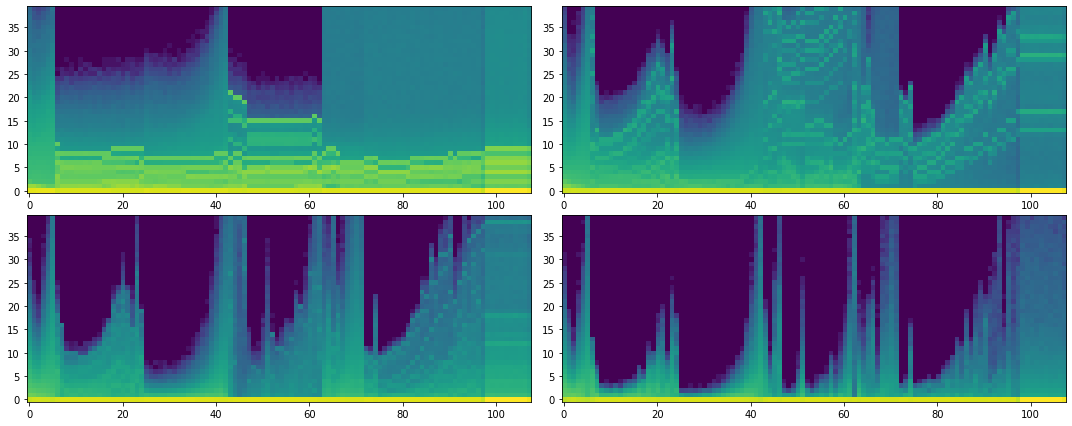

In [72]:
fig, axes = plt.subplots(2, 2, figsize=(15, 6))
for ax, h in zip(axes.flatten(), hooks[:4]):
  ax.imshow(get_hist(h), origin='lower')
#   ax.axis('off')
plt.tight_layout()

From the histograms, we can easily get more information like the min or max of the activations.

In [73]:
def get_min(h):
  h1 = torch.stack(h.stats[2]).t().float()
  return h1[:2].sum(0) / h1.sum(0)

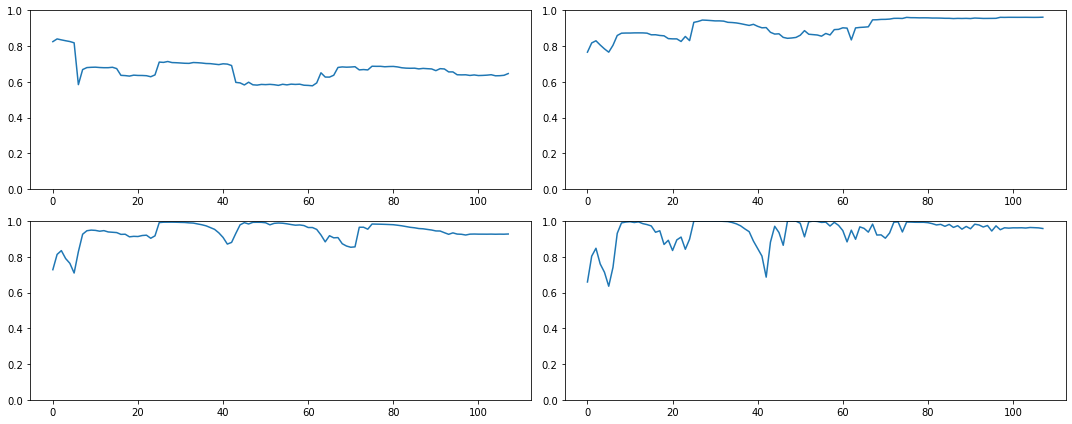

In [74]:
fig, axes = plt.subplots(2, 2, figsize=(15, 6))
for ax, h in zip(axes.flatten(), hooks[:4]):
  ax.plot(get_min(h))
  ax.set_ylim(0, 1)
plt.tight_layout()

## Generalized ReLU
Now let's use our model with a generalized ReLU that can be shifted and with maximum value.

In [75]:
#export
def get_cnn_layers(data, nfs, layer, **kwargs):
  nfs = [1] + nfs
  return [layer(nfs[i], nfs[i + 1], 5 if i == 0 else 3, **kwargs) for i in range(len(nfs) - 1)
         ] + [nn.AdaptiveAvgPool2d(1), Lambda(flatten), nn.Linear(nfs[-1], data.c)]

def conv_layer(ni, nf, ks=3, stride=2, **kwargs):
  return nn.Sequential(nn.Conv2d(ni, nf, ks, padding=ks//2, stride=stride),
                       GeneralReLU(**kwargs))

class GeneralReLU(nn.Module):
  def __init__(self, leak=None, sub=None, maxv=None):
    super(GeneralReLU, self).__init__()
    self.leak = leak
    self.sub = sub
    self.maxv = maxv
    
  def forward(self, x):
    x = F.leaky_relu(x, self.leak) if self.leak is not None else F.relu(x)
    if self.sub is not None:
      x.sub_(self.sub)
    if self.maxv is not None:
      x.clamp_max_(self.maxv)
    return x
  
def init_cnn(m, uniform=False):
  f = init.kaiming_uniform_ if uniform else init.kaiming_normal_
  for l in m:
    if isinstance(l, nn.Sequential):
      f(l[0].weight, a=0.1)
      l[0].bias.data.zero_()
      
def get_cnn_model(data, nfs, layer, **kwargs):
  return nn.Sequential(*get_cnn_layers(data, nfs, layer, **kwargs))

In [76]:
def append_stats(hook, mod, inp, outp):
  if not hasattr(hook, 'stats'):
    hook.stats = ([], [], [])
  means, stds, hists = hook.stats
  means.append(outp.data.mean().cpu())
  stds.append(outp.data.std().cpu())
  hists.append(outp.data.cpu().histc(40, -7, 7))

In [77]:
model = get_cnn_model(data, nfs, conv_layer, leak=0.1, sub=0.4, maxv=6.)
init_cnn(model)
learn, run = get_runner(model, data, lr=0.9, cbs=cbfs)

train: [0.50260328125, tensor(0.8403, device='cuda:0')]
valid: [0.1425693603515625, tensor(0.9583, device='cuda:0')]


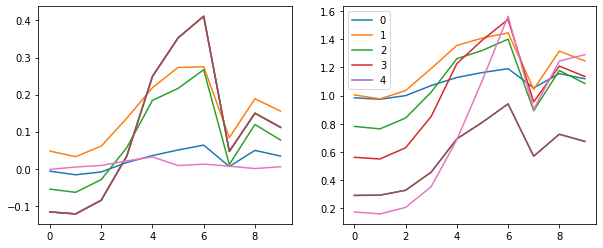

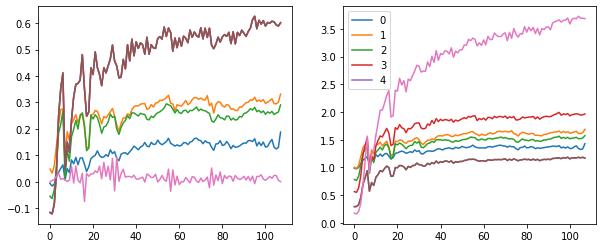

In [78]:
with Hooks(model, append_stats) as hooks:
  run.fit(1, learn)
  fig, (ax0, ax1) = plt.subplots(1, 2, figsize=(10, 4))
  for h in hooks:
    ms, ss, _ = h.stats
    ax0.plot(ms[:10])
    ax1.plot(ss[:10])
    h.remove()
  plt.legend(range(5))
  
  fig, (ax0, ax1) = plt.subplots(1, 2, figsize=(10, 4))
  for h in hooks:
    ms, ss, _ = h.stats
    ax0.plot(ms)
    ax1.plot(ss)
  plt.legend(range(5));

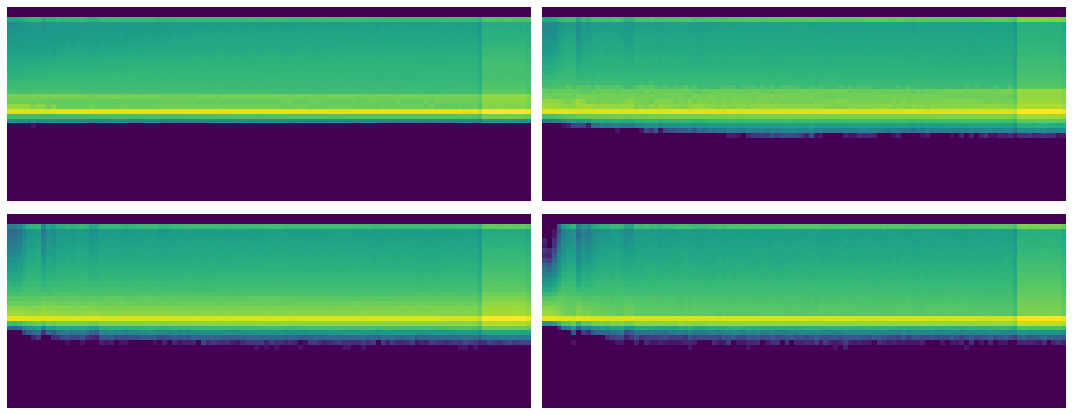

In [79]:
fig, axes = plt.subplots(2, 2, figsize=(15, 6))
for ax, h in zip(axes.flatten(), hooks[:4]):
  ax.imshow(get_hist(h), origin='lower')
  ax.axis('off')
plt.tight_layout()

In [80]:
def get_min(h):
  h1 = torch.stack(h.stats[2]).t().float()
  return h1[19: 22].sum(0) / h1.sum(0)

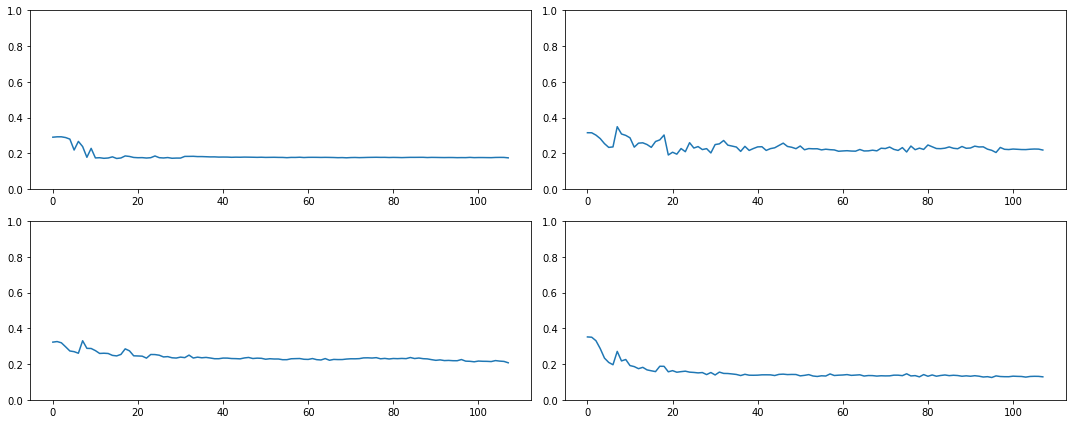

In [81]:
fig, axes = plt.subplots(2, 2, figsize=(15, 6))
for ax, h in zip(axes.flatten(), hooks[:4]):
  ax.plot(get_min(h))
  ax.set_ylim(0, 1)
plt.tight_layout()

In [82]:
#export
def get_learn_run(nfs, data, lr, layer, cbs=None, opt_func=None, uniform=False, **kwargs):
  model = get_cnn_model(data, nfs, layer, **kwargs)
  init_cnn(model, uniform=uniform)
  return get_runner(model, data, lr=lr, cbs=cbs, opt_func=opt_func)

In [83]:
sched = combine_scheds([0.5, 0.5], [sched_cos(0.2, 1.), sched_cos(1., 0.1)])

In [84]:
learn, run = get_learn_run(nfs, data, lr=1., layer=conv_layer, cbs=cbfs+[partial(ParamScheduler, 'lr', sched)])

In [85]:
run.fit(8, learn)

train: [1.12225578125, tensor(0.6670, device='cuda:0')]
valid: [0.44415478515625, tensor(0.8701, device='cuda:0')]
train: [0.31303138671875, tensor(0.9056, device='cuda:0')]
valid: [0.217790869140625, tensor(0.9346, device='cuda:0')]
train: [0.204491875, tensor(0.9389, device='cuda:0')]
valid: [0.10672158203125, tensor(0.9681, device='cuda:0')]
train: [0.10454833984375, tensor(0.9688, device='cuda:0')]
valid: [0.2446491455078125, tensor(0.9304, device='cuda:0')]
train: [0.4747906640625, tensor(0.8574, device='cuda:0')]
valid: [0.1083008056640625, tensor(0.9695, device='cuda:0')]
train: [0.0912803515625, tensor(0.9724, device='cuda:0')]
valid: [0.0888421142578125, tensor(0.9754, device='cuda:0')]
train: [0.064003359375, tensor(0.9810, device='cuda:0')]
valid: [0.074473681640625, tensor(0.9806, device='cuda:0')]
train: [0.0534564306640625, tensor(0.9842, device='cuda:0')]
valid: [0.07159764404296876, tensor(0.9802, device='cuda:0')]


Uniform init may provide more useful initial wegihts (normal distribution puts a lot of them at 0).

In [86]:
learn, run = get_learn_run(nfs, data, lr=1., layer=conv_layer, cbs=cbfs+[partial(ParamScheduler, 'lr', sched)], uniform=True)

In [87]:
run.fit(8, learn)

train: [1.075779453125, tensor(0.6606, device='cuda:0')]
valid: [0.356595263671875, tensor(0.8929, device='cuda:0')]
train: [0.3341003125, tensor(0.8969, device='cuda:0')]
valid: [0.675742138671875, tensor(0.7935, device='cuda:0')]
train: [0.20212482421875, tensor(0.9381, device='cuda:0')]
valid: [0.12692476806640626, tensor(0.9628, device='cuda:0')]
train: [0.1811662890625, tensor(0.9452, device='cuda:0')]
valid: [0.10311505126953124, tensor(0.9686, device='cuda:0')]
train: [0.0779814404296875, tensor(0.9761, device='cuda:0')]
valid: [0.08441455688476562, tensor(0.9760, device='cuda:0')]
train: [0.05755978515625, tensor(0.9821, device='cuda:0')]
valid: [0.07418020629882813, tensor(0.9782, device='cuda:0')]
train: [0.041669453125, tensor(0.9869, device='cuda:0')]
valid: [0.065432421875, tensor(0.9812, device='cuda:0')]
train: [0.03385457275390625, tensor(0.9900, device='cuda:0')]
valid: [0.062971923828125, tensor(0.9813, device='cuda:0')]


In [88]:
#export
from IPython.display import display, Javascript
def nb_auto_export():
  display(Javascript("""{
  const ip = IPython.notebook
  if (ip) {
    ip.save_notebook()
    console.log('a')
    const s = `!python notebook2script.py ${ip.notebook_name}`
    if (ip.kernel) { ip.kernel.execute(s) }
  }
  }"""))

In [1]:
!python notebook2script.py 06_cuda_cnn_hooks_init.ipynb

Converted 06_cuda_cnn_hooks_init.ipynb to nb_06.py
